# Keypoint Classification for Hand Gesture Recognition

https://github.com/kinivi/tello-gesture-control#Gesture-control

https://github.com/Kazuhito00/hand-gesture-recognition-using-mediapipe/tree/main

## Import Necessary Dependacies

In [387]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os 


SyntaxError: invalid syntax (864999259.py, line 10)

## Paths

In [368]:
keypoint_dataset = 'data/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

## Load the Training Data

In [369]:
X_dataset = np.loadtxt(keypoint_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(keypoint_dataset, delimiter=',', dtype='int32', usecols=(0))

## Splitting the data

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=34)

(array([0, 1]), array([1522, 1572], dtype=int64))


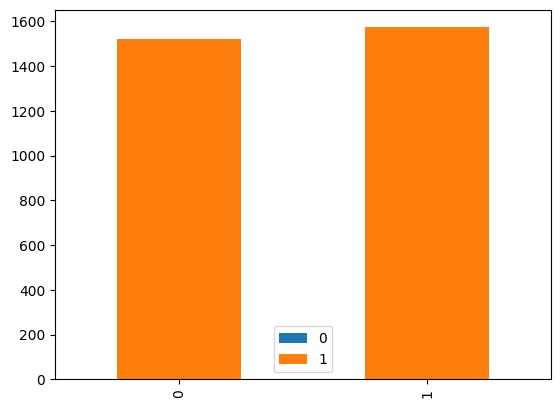

In [371]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

## Building the model

In [372]:
NUM_CLASSES = 2

In [373]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [374]:
model.summary() 

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_80 (Dropout)        (None, 42)                0         
                                                                 
 dense_104 (Dense)           (None, 32)                1376      
                                                                 
 dropout_81 (Dropout)        (None, 32)                0         
                                                                 
 dense_105 (Dense)           (None, 32)                1056      
                                                                 
 dropout_82 (Dropout)        (None, 32)                0         
                                                                 
 dense_106 (Dense)           (None, 16)                528       
                                                                 
 dense_107 (Dense)           (None, 2)               

In [375]:
# Model Checkpoints
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [376]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Training the model

In [377]:
# save model to plot a curve of accuracy and loss after training
history = model.fit(
    X_train,
    y_train,
    epochs=550,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/550
 1/19 [>.............................] - ETA: 9s - loss: 0.7034 - accuracy: 0.4688
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 1s 20ms/step - loss: 0.6546 - accuracy: 0.6379 - val_loss: 0.5955 - val_accuracy: 0.8488
Epoch 2/550
 1/19 [>.............................] - ETA: 0s - loss: 0.6004 - accuracy: 0.8438
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 6ms/step - loss: 0.5364 - accuracy: 0.8974 - val_loss: 0.4555 - val_accuracy: 0.9302
Epoch 3/550
 1/19 [>.............................] - ETA: 0s - loss: 0.4467 - accuracy: 0.9062
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 6ms/step - loss: 0.3817 - accuracy: 0.9198 - val_loss: 0.2939 - val_accuracy: 0.9341
Epoch 4/550
 1/19 [>.............................] - ETA: 0s - loss: 0.3127 - accuracy: 0.9062
Epoc

## Model Evaluation

### Confusion Matrix

In [378]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

25/25 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       372
           1       1.00      1.00      1.00       402

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774

[[372   0]
 [  2 400]]


## TF-Lite Deployment

#### Save the model (inference only)

In [379]:
model.save(model_save_path, include_optimizer=False)

#### Model Quantization

In [380]:
# Model Quantization
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmpd5j_k_xp\assets


INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmpd5j_k_xp\assets


7600

### Inference Test

In [381]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [382]:
# Input, Output Tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [383]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

### Inference Implementation

In [384]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [385]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.1402933e-07 9.9999964e-01]
1


## Download Model

In [386]:
# !zip -r model.zip keypoint_classifier
os.system("zip -r model.zip keypoint_classifier")

1